In [94]:
import pandas as pd
import numpy as np
import math
import sys
import os
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
pre_path = "./data/"

# Load data 


In [95]:
pre_file_list = os.listdir(pre_path)
data_df = pd.DataFrame()
col_list = []
for file in pre_file_list:
    #print(file)
    tmp_path = pre_path + file
    coin_type = file.split("USDT")[0]
    tmp_df = pd.read_csv(tmp_path)
    if len(col_list) == 0 and "close" in tmp_df.columns:
        col_list = tmp_df.columns
    out = [i for i, j in zip(col_list, tmp_df.columns) if i != j]
    if len(out) != 0:
        tmp_df = pd.read_csv(tmp_path,header = None)
        tmp_df.columns = col_list
    tmp_df["coin_type"] = coin_type
    tmp_df['open_time'] = tmp_df['open_time'].apply(lambda x: x//1000)
    tmp_df['open_time'] = pd.to_datetime(tmp_df['open_time'],unit='s')
    tmp_df['close_time'] = tmp_df['close_time'].apply(lambda x: x//1000)
    tmp_df['close_time'] = pd.to_datetime(tmp_df['close_time'],unit='s')
    data_df = pd.concat([data_df,tmp_df],axis = 0, ignore_index=True)

data_df = data_df.sort_values(by=['open_time',"coin_type"], ascending=True)
data_df = data_df.reset_index(drop = True)
display(data_df)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,coin_type
0,2022-01-01 00:00:00,1.30770,1.33280,1.30760,1.32910,1.461367e+07,2022-01-01 00:59:59,1.930024e+07,29050,7.568545e+06,9.993614e+06,0,ADA
1,2022-01-01 00:00:00,511.55000,517.85000,511.43000,517.42000,2.932202e+04,2022-01-01 00:59:59,1.509610e+07,22736,1.591227e+04,8.192958e+06,0,BNB
2,2022-01-01 00:00:00,46210.57000,46729.73000,46210.55000,46650.01000,8.957465e+03,2022-01-01 00:59:59,4.164448e+08,91267,4.777701e+03,2.221296e+08,0,BTC
3,2022-01-01 00:00:00,3676.01000,3730.00000,3676.01000,3721.67000,4.583592e+04,2022-01-01 00:59:59,1.698204e+08,67207,2.553325e+04,9.462762e+07,0,ETH
4,2022-01-01 00:00:00,0.45057,0.45797,0.45002,0.45756,3.289705e+07,2022-01-01 00:59:59,1.494042e+07,30227,1.714832e+07,7.788349e+06,0,GALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165471,2023-11-30 23:00:00,0.26040,0.26210,0.25980,0.26190,1.004176e+07,2023-11-30 23:59:59,2.621476e+06,7398,5.443095e+06,1.421194e+06,0,GMT
165472,2023-11-30 23:00:00,14.31900,14.41000,14.28700,14.40700,4.770194e+05,2023-11-30 23:59:59,6.848692e+06,16444,2.734755e+05,3.927484e+06,0,LINK
165473,2023-11-30 23:00:00,0.76070,0.76330,0.75760,0.76260,1.260543e+07,2023-11-30 23:59:59,9.591372e+06,18852,6.195142e+06,4.714729e+06,0,MATIC
165474,2023-11-30 23:00:00,59.28400,59.30900,58.95300,59.30900,8.111330e+05,2023-11-30 23:59:59,4.799254e+07,54419,4.226510e+05,2.501009e+07,0,SOL


In [96]:
data_df = data_df.sort_values(['coin_type','open_time']).reset_index(drop=True)

# 1) Compute simple hourly return per coin:
#    r_{t} = (close_{t} / close_{t−1}) − 1
data_df['return'] = (
    data_df
    .groupby('coin_type')['close']
    .pct_change()           # percent change from previous timestamp (same coin)
)

# 2) (Optional) Drop the very first row per coin where return is NaN:
data_df = data_df.dropna(subset=['return']).reset_index(drop=True)

# Prepare data (Just using BTC)

In [5]:
# For illustration, let’s pick one coin: “BTCUSDT”
COIN = "BTC"

# 1) Filter for that coin and sort
df = data_df[data_df['coin_type'] == COIN].sort_values('open_time').reset_index(drop=True)

# 2) Compute the basic “label”: direction of next‐hour return
#    Label_t = 1 if return_{t+1} > 0, else 0.  We'll need to shift.
df['return'] = df['return']  # already exists
df['label_up'] = (df['return'].shift(-1) > 0).astype(int)

In [6]:
MAX_LAG = 6
L_MOM = 24
L_VOL = 24

for lag in range(1, MAX_LAG + 1):
    df[f'lag_ret_{lag}'] = df['return'].shift(lag)

df['mom_24h'] = df['close'].pct_change(periods=L_MOM)
df['vol_24h'] = df['return'].rolling(window=L_VOL, min_periods=L_VOL).std()

# 4) Drop NaNs in features/label
feature_cols = [f'lag_ret_{lag}' for lag in range(1, MAX_LAG + 1)] + ['mom_24h', 'vol_24h']
df_model = df.dropna(subset=feature_cols + ['label_up']).reset_index(drop=True)

# 5) Chronological split: Train/Val/Test
train_end = pd.to_datetime("2023-03-31 23:00:00")
val_end   = pd.to_datetime("2023-07-31 23:00:00")

train_mask = df_model['open_time'] <= train_end
val_mask   = (df_model['open_time'] > train_end) & (df_model['open_time'] <= val_end)
test_mask  = df_model['open_time'] > val_end

X_all = df_model[feature_cols].values
y_all = df_model['label_up'].values
times = df_model['open_time']
returns_series = df_model['return']

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# Standardize features for models that require scaling (Lasso, LSTM)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)

In [7]:
def compute_sharpe_from_signal(signal_series, returns_series):
    pnl = signal_series.shift(1).fillna(0) * returns_series
    avg_ret = pnl.mean()
    std_ret = pnl.std(ddof=0)
    return (avg_ret / std_ret) * np.sqrt(8760) if std_ret != 0 else np.nan, pnl, (1 + pnl.fillna(0)).cumprod()


# Training 

In [8]:
val_indices = df_model.index[val_mask]
test_indices = df_model.index[test_mask]

# Container for best models and their results
best_models = {}
model_results = {}

In [9]:

lasso_params = {'C': [0.01, 0.1, 1, 10, 100]}
best_sharpe = -np.inf
for C in lasso_params['C']:
    model = LogisticRegression(penalty='l1', solver='saga', C=C, max_iter=10000)
    model.fit(X_train_std, y_train)
    val_prob = model.predict_proba(X_val_std)[:,1]
    thr = 0.5
    sig = pd.Series(index=val_indices, data=0)
    sig[val_prob > thr] = 1
    sig[val_prob < (1 - thr)] = -1
    sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
    if sharpe_val > best_sharpe:
        best_sharpe = sharpe_val
        best_models['Lasso'] = {'model': model, 'C': C, 'threshold': thr, 'sharpe_val': sharpe_val}


In [10]:
xgb_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
best_sharpe = -np.inf
for n_est in xgb_grid['n_estimators']:
    for md in xgb_grid['max_depth']:
        for lr in xgb_grid['learning_rate']:
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                  n_estimators=n_est, max_depth=md,
                                  learning_rate=lr, random_state=42, verbosity=0)
            model.fit(X_train, y_train)
            val_prob = model.predict_proba(X_val)[:,1]
            thr = 0.5
            sig = pd.Series(index=val_indices, data=0)
            sig[val_prob > thr] = 1
            sig[val_prob < (1 - thr)] = -1
            sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['XGBoost'] = {'model': model, 'n_estimators': n_est,
                                          'max_depth': md, 'learning_rate': lr,
                                          'threshold': thr, 'sharpe_val': sharpe_val}


In [11]:
cat_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
best_sharpe = -np.inf
for it in cat_grid['iterations']:
    for d in cat_grid['depth']:
        for lr in cat_grid['learning_rate']:
            model = CatBoostClassifier(iterations=it, depth=d, learning_rate=lr,
                                       verbose=False, random_state=42)
            model.fit(X_train, y_train)
            val_prob = model.predict_proba(X_val)[:,1]
            thr = 0.5
            sig = pd.Series(index=val_indices, data=0)
            sig[val_prob > thr] = 1
            sig[val_prob < (1 - thr)] = -1
            sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['CatBoost'] = {'model': model, 'iterations': it,
                                          'depth': d, 'learning_rate': lr,
                                          'threshold': thr, 'sharpe_val': sharpe_val}


In [12]:
seq_features = [f'lag_ret_{lag}' for lag in range(1, MAX_LAG + 1)]

class LagDataset(Dataset):
    def __init__(self, df_model, mask, seq_features, label_col='label_up'):
        self.indices = df_model.index[mask]
        self.X = df_model.loc[mask, seq_features].values.astype('float32')
        self.y = df_model.loc[mask, label_col].values.astype('float32')
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        seq = self.X[idx].reshape(-1, 1)  # (seq_len, 1)
        return seq, self.y[idx]

def train_lstm_model(hidden_size, lr, epochs):
    # Prepare DataLoaders
    train_ds = LagDataset(df_model, train_mask, seq_features)
    val_ds   = LagDataset(df_model, val_mask, seq_features)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
    
    # Define model
    class LSTMModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=16, num_layers=1):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc   = nn.Linear(hidden_size, 1)
        def forward(self, x):
            out, _ = self.lstm(x)
            h_last = out[:, -1, :]
            return torch.sigmoid(self.fc(h_last)).squeeze()
    
    model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=1)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        for seq_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(seq_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
    
    # Validation inference
    model.eval()
    val_probs = []
    with torch.no_grad():
        for seq_batch, _ in val_loader:
            val_probs.append(model(seq_batch).numpy())
    val_probs = np.concatenate(val_probs, axis=0)
    
    thr = 0.5
    sig = pd.Series(index=val_indices, data=0)
    sig[val_probs > thr] = 1
    sig[val_probs < (1 - thr)] = -1
    sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
    return model, sharpe_val

# Hyperparameter grids for LSTM
hidden_sizes = [8, 16]
lrs = [1e-3, 1e-2]
epochs_list = [5, 10]

best_sharpe = -np.inf
for hs in hidden_sizes:
    for lr in lrs:
        for ep in epochs_list:
            model, sharpe_val = train_lstm_model(hs, lr, ep)
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['LSTM'] = {'model': model, 'hidden_size': hs,
                                       'learning_rate': lr, 'epochs': ep,
                                       'threshold': 0.5, 'sharpe_val': sharpe_val}


Test Sharpe Ratios:
Lasso: Sharpe=-0.75
XGBoost: Sharpe=-1.74
CatBoost: Sharpe=0.91
LSTM: Sharpe=2.20


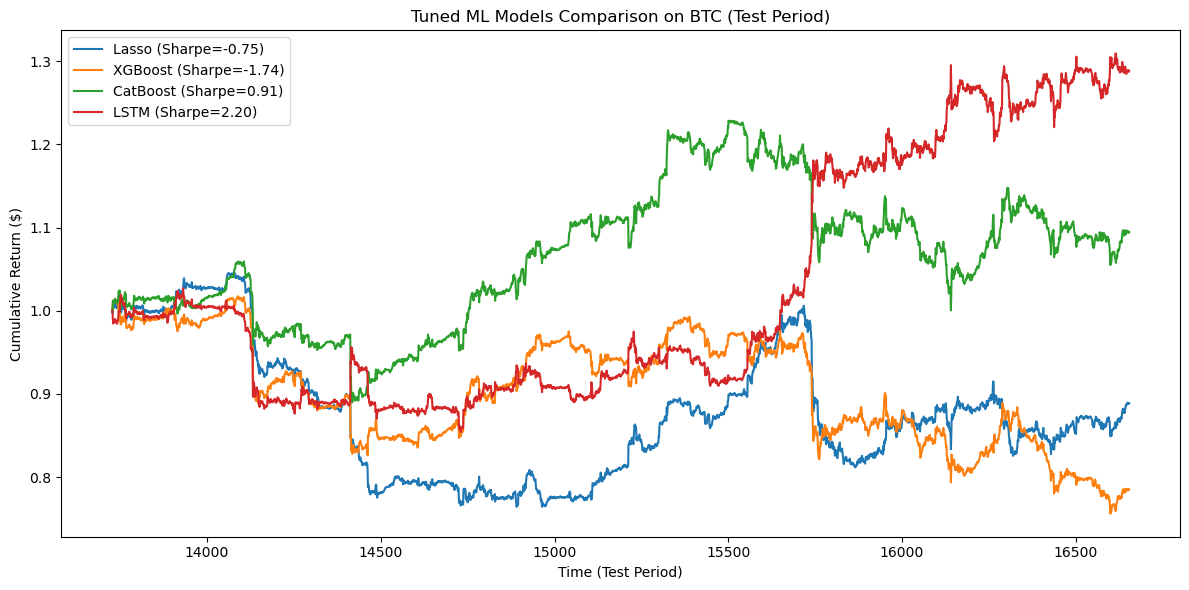


Best Hyperparameters:
Lasso: {'C': 1, 'threshold': 0.5, 'sharpe_val': 0.3612356994180074}
XGBoost: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'threshold': 0.5, 'sharpe_val': 0.4049361088021661}
CatBoost: {'iterations': 200, 'depth': 3, 'learning_rate': 0.01, 'threshold': 0.5, 'sharpe_val': 0.2006895358771506}
LSTM: {'hidden_size': 8, 'learning_rate': 0.001, 'epochs': 5, 'threshold': 0.5, 'sharpe_val': 0.4064472994346425}


In [13]:
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
print("Test Sharpe Ratios:")
for name, info in best_models.items():
    if name in ['Lasso', 'XGBoost', 'CatBoost']:
        model = info['model']
        thr = info['threshold']
        # Choose correct features & scaling
        if name == 'Lasso':
            probs = model.predict_proba(X_test_std)[:, 1]
        else:
            probs = model.predict_proba(X_test)[:, 1]
        sig = pd.Series(index=test_indices, data=0)
        sig[probs > thr] = 1
        sig[probs < (1 - thr)] = -1
        sharpe_test, _, cum_pnl = compute_sharpe_from_signal(sig, returns_series[test_mask])
        print(f"{name}: Sharpe={sharpe_test:.2f}")
        model_results[name] = cum_pnl
        plt.plot(cum_pnl.index, cum_pnl.values, label=f"{name} (Sharpe={sharpe_test:.2f})", linewidth=1.5)
    elif name == 'LSTM':
        model = info['model']
        # Build test DataLoader
        test_ds = LagDataset(df_model, test_mask, seq_features)
        test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)
        model.eval()
        test_probs = []
        with torch.no_grad():
            for seq_batch, _ in test_loader:
                test_probs.append(model(seq_batch).numpy())
        test_probs = np.concatenate(test_probs, axis=0)
        thr = info['threshold']
        sig = pd.Series(index=test_indices, data=0)
        sig[test_probs > thr] = 1
        sig[test_probs < (1 - thr)] = -1
        sharpe_test, _, cum_pnl = compute_sharpe_from_signal(sig, returns_series[test_mask])
        print(f"{name}: Sharpe={sharpe_test:.2f}")
        model_results[name] = cum_pnl
        plt.plot(cum_pnl.index, cum_pnl.values, label=f"{name} (Sharpe={sharpe_test:.2f})", linewidth=1.5)

plt.xlabel("Time (Test Period)")
plt.ylabel("Cumulative Return ($)")
plt.title(f"Tuned ML Models Comparison on {COIN} (Test Period)")
plt.legend()
plt.tight_layout()
plt.show()

# 8) Display best hyperparameters
print("\nBest Hyperparameters:")
for name, info in best_models.items():
    print(f"{name}: { {k: v for k, v in info.items() if k not in ['model']} }")


# Autoencoder

## Seq-to-Seq Auotencoder

In [37]:
df = data_df.copy()
df['open_time'] = pd.to_datetime(df['open_time'])
df['return'] = df.groupby('coin_type')['close'].transform(lambda x: x.pct_change())
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
df['RSI14'] = df.groupby('coin_type')['close'].transform(lambda x: compute_rsi(x, 14))
df['EMA14'] = df.groupby('coin_type')['close'].transform(lambda x: x.ewm(span=14, adjust=False).mean())
df = df.dropna(subset=['return','volume','RSI14','EMA14']).reset_index(drop=True)

# Pivot wide
features = ['return','volume','RSI14','EMA14']
wide = {feat: df.pivot(index='open_time', columns='coin_type', values=feat).sort_index() for feat in features}
for k in wide:
    wide[k] = wide[k].ffill().dropna()
times = wide['return'].index
coins = wide['return'].columns.tolist()
T = len(times); D = len(coins)*len(features)
X = np.stack([wide[f].values for f in features], axis=-1).reshape(T, D)

# Sequence dataset
H = 24
seqs, seq_times = [], []
for i in range(H-1, T-1):
    seqs.append(X[i-H+1:i+1]); seq_times.append(times[i])
X_seq = np.stack(seqs); N = len(X_seq)
R = wide['return'].values; pnl_returns = R[H:]

# Train/Val/Test split
train_end = int(0.6 * N); val_end = int(0.8 * N)
X_train, X_val, X_test = X_seq[:train_end], X_seq[train_end:val_end], X_seq[val_end:]
pnl_test = pnl_returns[val_end:]

# Scale
mu = X_train.reshape(-1, D).mean(axis=0)
sigma = X_train.reshape(-1, D).std(axis=0); sigma[sigma==0]=1
for arr in [X_train, X_val, X_test]:
    arr -= mu; arr /= sigma

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)),
                          batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.tensor(X_val,   dtype=torch.float32)),
                          batch_size=64, shuffle=False)

# Seq2Seq AE
class Seq2SeqAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # encoder: input_dim → hidden_dim
        self.enc_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.enc_fc   = nn.Linear(hidden_dim, latent_dim)
        # decoder: hidden_dim input, but hidden_size=input_dim (to reconstruct)
        self.dec_fc   = nn.Linear(latent_dim, input_dim)       # ← map latent → hidden_size
        self.dec_lstm = nn.LSTM(hidden_dim, input_dim, batch_first=True)

    def forward(self, x):
        B, H, D = x.size()
        # 1) encode
        _, (h, _) = self.enc_lstm(x)      # h: (1, B, hidden_dim)
        z = self.enc_fc(h[-1])            # z: (B, latent_dim)

        # 2) prepare decoder hidden state of size = input_dim
        dec_h = self.dec_fc(z).unsqueeze(0)           # (1, B, input_dim)
        dec_c = torch.zeros_like(dec_h)               # same shape

        # 3) zero‐inputs of size hidden_dim
        dec_in = torch.zeros(B, H, h.size(-1), device=x.device)  # (B, H, hidden_dim)

        # 4) decode
        out, _ = self.dec_lstm(dec_in, (dec_h, dec_c))
        # out: (B, H, input_dim) → this matches your original x shape

        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2SeqAE(input_dim=D, hidden_dim=64, latent_dim=16).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()

# Training
best_val = np.inf
for epoch in range(1, 31):
    model.train()
    tl=0
    for (b,) in train_loader:
        b=b.to(device)
        rec=model(b)
        loss=crit(rec,b)
        opt.zero_grad(); loss.backward(); opt.step()
        tl+=loss.item()*b.size(0)
    tl/=len(X_train)
    # val
    model.eval(); vl=0
    with torch.no_grad():
        for (b,) in val_loader:
            b=b.to(device)
            vl+=crit(model(b),b).item()*b.size(0)
    vl/=len(X_val)
    if vl<best_val:
        best_val=vl; torch.save(model.state_dict(),'best_seq2seq.pth')
    print(f"Epoch {epoch}, Train MSE {tl:.6f}, Val MSE {vl:.6f}")
model.load_state_dict(torch.load('best_seq2seq.pth'))

# Test recon error
model.eval()
with torch.no_grad():
    Xt=torch.tensor(X_test,dtype=torch.float32).to(device)
    rec=model(Xt).cpu().numpy()

# Extract return errors at last time-step
E_test=[]
for i in range(len(X_test)):
    orig = X_test[i,-1]*sigma + mu
    recon= rec[i,-1]*sigma + mu
    orig_ret, recon_ret = orig[0::4], recon[0::4]
    E_test.append(orig_ret - recon_ret)
E_test=np.stack(E_test)  # (N_test,10)


Epoch 1, Train MSE 0.931984, Val MSE 0.732332
Epoch 2, Train MSE 0.837818, Val MSE 0.696870
Epoch 3, Train MSE 0.774991, Val MSE 0.647082
Epoch 4, Train MSE 0.747243, Val MSE 0.629058
Epoch 5, Train MSE 0.731292, Val MSE 0.616788
Epoch 6, Train MSE 0.717953, Val MSE 0.611085
Epoch 7, Train MSE 0.708181, Val MSE 0.602889
Epoch 8, Train MSE 0.701230, Val MSE 0.597250
Epoch 9, Train MSE 0.695446, Val MSE 0.595712
Epoch 10, Train MSE 0.691058, Val MSE 0.589553
Epoch 11, Train MSE 0.686900, Val MSE 0.590592
Epoch 12, Train MSE 0.684137, Val MSE 0.587831
Epoch 13, Train MSE 0.681105, Val MSE 0.584842
Epoch 14, Train MSE 0.677001, Val MSE 0.584705
Epoch 15, Train MSE 0.671806, Val MSE 0.578002
Epoch 16, Train MSE 0.666093, Val MSE 0.576856
Epoch 17, Train MSE 0.662470, Val MSE 0.572710
Epoch 18, Train MSE 0.658856, Val MSE 0.570568
Epoch 19, Train MSE 0.658698, Val MSE 0.568491
Epoch 20, Train MSE 0.652976, Val MSE 0.567896
Epoch 21, Train MSE 0.650090, Val MSE 0.569823
Epoch 22, Train MSE 0.

Test Avg Ret: 0.0054%, Sharpe: 1.97, Cumul: 1.16x


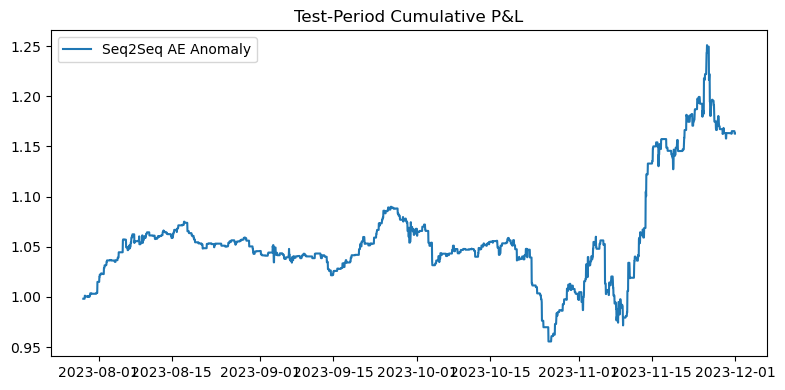

In [38]:

# Dynamic threshold & backtest
times_test = seq_times[val_end:]
pnl=[]
for i,t in enumerate(times_test):
    e = E_test[i]
    th = np.quantile(np.abs(e),0.85)
    imax, imin = e.argmax(), e.argmin()
    if e[imax]>th and e[imin]<-th:
        w = np.zeros(10); w[imin], w[imax] = 0.5, -0.5
        pnl.append(w.dot(pnl_test[i]))
    else:
        pnl.append(0.0)

bt = pd.Series(pnl,index=times_test).dropna()
avg, std = bt.mean(), bt.std(ddof=0)
sh, cum = avg/std*np.sqrt(8760), (1+bt).cumprod().iloc[-1]

print(f"Test Avg Ret: {avg:.4%}, Sharpe: {sh:.2f}, Cumul: {cum:.2f}x")
plt.figure(figsize=(8,4))
plt.plot(bt.index, (1+bt).cumprod(), label='Seq2Seq AE Anomaly')
plt.legend(); plt.title('Test‐Period Cumulative P&L'); plt.tight_layout(); plt.show()

## Denoising autoencoder

In [48]:

# 7) SEQ2SEQ LSTM DENOISING AUTOENCODER
class Seq2SeqDAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Encoder
        self.enc_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.enc_fc   = nn.Linear(hidden_dim, latent_dim)
        # Decoder initialization
        self.dec_fc   = nn.Linear(latent_dim, input_dim)       # maps z -> initial hidden_size
        self.dec_lstm = nn.LSTM(hidden_dim, input_dim, batch_first=True)
    def forward(self, x):
        # Encode
        _, (h, _) = self.enc_lstm(x)
        z = self.enc_fc(h[-1])  # (B, latent_dim)
        # Prepare decoder hidden state (size=input_dim)
        dec_h = self.dec_fc(z).unsqueeze(0)  # (1, B, input_dim)
        dec_c = torch.zeros_like(dec_h)
        # Decoder zero-inputs (size=hidden_dim)
        B, H, _ = x.size()
        hidden_dim = h.size(-1)
        dec_in = torch.zeros(B, H, hidden_dim, device=x.device)
        # Decode
        out, _ = self.dec_lstm(dec_in, (dec_h, dec_c))
        return out

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2SeqDAE(input_dim=D, hidden_dim=64, latent_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
noise_std = 0.01  # standard deviation for Gaussian noise

# 8) TRAIN WITH DENOISING & EARLY STOPPING
best_val_loss = np.inf
for epoch in range(1, 31):
    # Training
    model.train()
    train_loss = 0.0
    for (batch,) in train_loader:
        batch = batch.to(device)
        # Add Gaussian noise
        noisy = batch + noise_std * torch.randn_like(batch)
        recon = model(noisy)
        loss = criterion(recon, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    train_loss /= len(X_train)
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (batch,) in val_loader:
            batch = batch.to(device)
            recon = model(batch)  # no noise in validation
            val_loss += criterion(recon, batch).item() * batch.size(0)
    val_loss /= len(X_val)
    # Checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_dae.pth')
    print(f"Epoch {epoch:02d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")


Epoch 01 | Train MSE: 0.929873 | Val MSE: 0.731424
Epoch 02 | Train MSE: 0.839665 | Val MSE: 0.716180
Epoch 03 | Train MSE: 0.777502 | Val MSE: 0.645107
Epoch 04 | Train MSE: 0.738830 | Val MSE: 0.634408
Epoch 05 | Train MSE: 0.724485 | Val MSE: 0.629174
Epoch 06 | Train MSE: 0.713004 | Val MSE: 0.624442
Epoch 07 | Train MSE: 0.701029 | Val MSE: 0.616210
Epoch 08 | Train MSE: 0.698166 | Val MSE: 0.611091
Epoch 09 | Train MSE: 0.685837 | Val MSE: 0.612398
Epoch 10 | Train MSE: 0.676363 | Val MSE: 0.607595
Epoch 11 | Train MSE: 0.670361 | Val MSE: 0.605616
Epoch 12 | Train MSE: 0.666052 | Val MSE: 0.598892
Epoch 13 | Train MSE: 0.662396 | Val MSE: 0.598540
Epoch 14 | Train MSE: 0.659557 | Val MSE: 0.597146
Epoch 15 | Train MSE: 0.657069 | Val MSE: 0.596251
Epoch 16 | Train MSE: 0.653475 | Val MSE: 0.591816
Epoch 17 | Train MSE: 0.650720 | Val MSE: 0.584887
Epoch 18 | Train MSE: 0.647893 | Val MSE: 0.586441
Epoch 19 | Train MSE: 0.645173 | Val MSE: 0.583532
Epoch 20 | Train MSE: 0.642604 


Denoising Seq2Seq DAE Anomaly Backtest (TEST)
Avg hourly return = 0.0063%
Std dev hourly    = 0.2600%
Annualized Sharpe = 2.26
Cumulative return = 1.19x


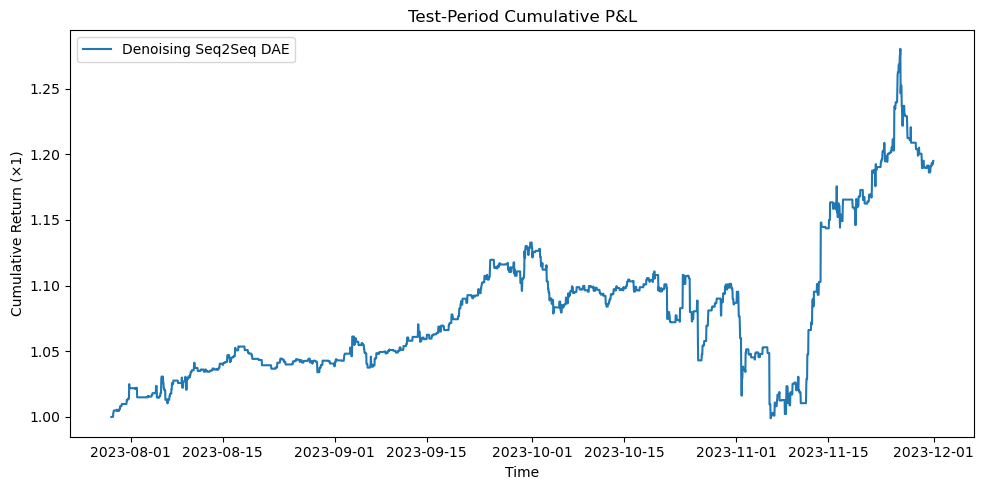

In [49]:

# Load best model
model.load_state_dict(torch.load('best_dae.pth'))
model.eval()

# 9) TEST‐PERIOD RECONSTRUCTION & ERROR EXTRACTION
with torch.no_grad():
    Xt = torch.tensor(X_test, dtype=torch.float32).to(device)
    rec = model(Xt).cpu().numpy()

# Compute errors on return features at last time step
E_test = []
for i in range(len(X_test)):
    orig = X_test[i, -1] * sigma + mu
    recon= rec[i, -1] * sigma + mu
    # extract return column indices
    ret_orig = orig[0::4]
    ret_recon= recon[0::4]
    E_test.append(ret_orig - ret_recon)
E_test = np.stack(E_test)  # shape (N_test,10)

# 10) DYNAMIC CROSS‐SECTIONAL THRESHOLD & BACKTEST
times_test = seq_times[val_end:]
pnl = []
for i, t in enumerate(times_test):
    errs = E_test[i]
    th = np.quantile(np.abs(errs), 0.85)  # hour‐specific threshold
    i_max = np.argmax(errs)
    i_min = np.argmin(errs)
    if errs[i_max] > th and errs[i_min] < -th:
        w = np.zeros(10)
        w[i_min], w[i_max] = +0.5, -0.5
        pnl.append(w.dot(pnl_test[i]))
    else:
        pnl.append(0.0)

bt = pd.Series(pnl, index=times_test).dropna()
avg_ret = bt.mean()
std_ret = bt.std(ddof=0)
sharpe = avg_ret / std_ret * np.sqrt(8760)
cum_ret = (1 + bt).cumprod().iloc[-1]

print(f"\nDenoising Seq2Seq DAE Anomaly Backtest (TEST)")
print(f"Avg hourly return = {avg_ret:.4%}")
print(f"Std dev hourly    = {std_ret:.4%}")
print(f"Annualized Sharpe = {sharpe:.2f}")
print(f"Cumulative return = {cum_ret:.2f}x")

plt.figure(figsize=(10,5))
plt.plot(bt.index, (1 + bt).cumprod(), label='Denoising Seq2Seq DAE')
plt.xlabel('Time'); plt.ylabel('Cumulative Return (×1)')
plt.title('Test‐Period Cumulative P&L')
plt.legend(); plt.tight_layout(); plt.show()

# Reinforcement Learning

In [97]:
import torch.optim as optim
import random
from collections import deque
from torch.distributions import Categorical
from torch.distributions import Normal
COIN_LIST   = list(data_df["coin_type"].unique())

In [98]:

TRAIN_END    = pd.Timestamp("2022-12-31 23:00:00")
VALID_END    = pd.Timestamp("2023-06-30 23:00:00")
TEST_START   = pd.Timestamp("2023-07-01 00:00:00")

ROLLOUT_LEN  = 2048
K_EPOCHS     = 4
GAMMA        = 0.99
LAMBDA       = 0.95
EPS_CLIP     = 0.2
LR           = 3e-4
LSTM_HIDDEN  = 256
GSAGE_HIDDEN = 32
MAX_UPDATES  = 500
SEED         = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [99]:

# ------------------------------------------------------------
# 1. FEATURE ENGINEERING PER COIN
# ------------------------------------------------------------
def compute_technical_indicators(df):
    df["return"] = df["close"].pct_change().fillna(0.0)
    df["mom"]    = df["close"].pct_change(24).fillna(0.0)
    df["vol"]    = df["return"].rolling(24, min_periods=1).std().fillna(0.0)
    # RSI
    delta = df["close"].diff().fillna(0.0)
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.rolling(14, min_periods=14).mean()
    avg_loss = loss.rolling(14, min_periods=14).mean()
    for i in range(14, len(df)):
        avg_gain.iat[i] = (avg_gain.iat[i-1]*13 + gain.iat[i])/14
        avg_loss.iat[i] = (avg_loss.iat[i-1]*13 + loss.iat[i])/14
    rs = avg_gain/(avg_loss.replace(0, np.nan))
    df["rsi"] = (100 - 100/(1+rs)).fillna(0.0)
    # MACD & BBands
    df["ema12"] = df["close"].ewm(span=12,adjust=False).mean()
    df["ema26"] = df["close"].ewm(span=26,adjust=False).mean()
    df["macd"]  = (df["ema12"]-df["ema26"]).fillna(0.0)
    df["bb_m"]  = df["close"].rolling(20, min_periods=1).mean()
    df["bb_s"]  = df["close"].rolling(20, min_periods=1).std().fillna(0.0)
    df["bb_h"]  = df["bb_m"] + 2*df["bb_s"]
    df["bb_l"]  = df["bb_m"] - 2*df["bb_s"]
    # Time
    df["hour"]     = df["open_time"].dt.hour
    df["dow"]      = df["open_time"].dt.dayofweek
    df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
    df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)
    df["dow_sin"]  = np.sin(2*np.pi*df["dow"]/7)
    df["dow_cos"]  = np.cos(2*np.pi*df["dow"]/7)
    return df.dropna().reset_index(drop=True)

# Assume data_df is loaded and has ['open_time','close','coin_type']
coin_data = {}
for coin in COIN_LIST:
    df = data_df[data_df["coin_type"]==coin].copy()
    df = df.sort_values("open_time").reset_index(drop=True)
    df = compute_technical_indicators(df)
    t0 = max(5,24,24,14,26,20)
    N  = len(df) - t0 - 1
    states, rets, times = [], [], []
    for i in range(N):
        t = t0 + i
        lag_r = df["return"].iloc[t-5:t].values[::-1]
        feat = df[["mom","vol","rsi","macd","bb_h","bb_l",
                   "hour_sin","hour_cos","dow_sin","dow_cos"]].iloc[t].values
        states.append(np.hstack([lag_r, feat]))
        rets.append(df["return"].iloc[t+1])
        times.append(df["open_time"].iloc[t])
    coin_data[coin] = {
        "states":  np.array(states, dtype=np.float32),
        "returns": np.array(rets,   dtype=np.float32),
        "times":   np.array(times)
    }


In [100]:

# ------------------------------------------------------------
# 2. UNIFIED TIME SERIES & CROSS-COIN FEATURES
# ------------------------------------------------------------
all_sets     = [set(coin_data[c]["times"]) for c in COIN_LIST]
common_times = sorted(set.intersection(*all_sets))
T_total      = len(common_times) - 1
per_dim      = coin_data[COIN_LIST[0]]["states"].shape[1]

raw_states = np.zeros((T_total, per_dim*len(COIN_LIST)), dtype=np.float32)
rets_full  = np.zeros((T_total, len(COIN_LIST)), dtype=np.float32)
times_full = []

for t in range(T_total):
    tm, feats, rv = common_times[t], [], []
    for coin in COIN_LIST:
        cd  = coin_data[coin]
        idx = np.searchsorted(cd["times"], tm)
        feats.append(cd["states"][idx])
        rv.append(cd["returns"][idx])
    raw_states[t] = np.hstack(feats)
    rets_full[t]  = np.array(rv, dtype=np.float32)
    times_full.append(tm)
times_full = np.array(times_full)

# Correlation vs BTC over last 24h
window = 24
corr_feats = []
for t in range(T_total):
    if t<window:
        corr_feats.append(np.zeros(len(COIN_LIST)))
    else:
        slice_rets = rets_full[t-window:t]
        btc_rets   = slice_rets[:,0]
        cs = [np.corrcoef(btc_rets, slice_rets[:,j])[0,1] 
              for j in range(len(COIN_LIST))]
        corr_feats.append(np.nan_to_num(cs))
corr_feats = np.array(corr_feats, dtype=np.float32)

# Market regime flag
global_vol = rets_full.std(axis=1)
thr = np.median(global_vol)
regime = np.vstack([global_vol>thr, global_vol<=thr]).T.astype(np.float32)

states_full = np.hstack([raw_states, corr_feats, regime])
state_dim   = states_full.shape[1]

mask_train = times_full <= TRAIN_END
mask_valid = (times_full>TRAIN_END)&(times_full<=VALID_END)
mask_test  = times_full>=TEST_START

In [101]:

# ------------------------------------------------------------
# 3. ADJACENCY MATRIX FOR GRAPHSAGE
# ------------------------------------------------------------
train_corr = np.corrcoef(rets_full[mask_train], rowvar=False)
abs_corr   = np.abs(train_corr)
threshold  = np.median(abs_corr)
A          = (abs_corr >= threshold).astype(float)
np.fill_diagonal(A, 1.0)
D_inv      = np.diag(1.0/A.sum(axis=1))
A_norm     = D_inv.dot(A)
adj        = torch.tensor(A_norm, dtype=torch.float32).to(DEVICE)

# ------------------------------------------------------------
# 4. PORTFOLIO ENVIRONMENT (multi‐coin baskets ≤2)
# ------------------------------------------------------------
from itertools import combinations
class CryptoPortfolioEnv:
    def __init__(self, states, returns, txn_cost, risk_penalty, sharpe_bonus):
        self.states       = states
        self.returns      = returns
        self.txn_cost     = txn_cost
        self.risk_penalty = risk_penalty
        self.sharpe_bonus = sharpe_bonus
        self.n, self.nc   = len(states), returns.shape[1]
        self.action_map   = {0: np.zeros(self.nc)}
        aid = 1
        for i in range(self.nc):
            v = np.zeros(self.nc); v[i]=1
            self.action_map[aid] = v.copy(); aid+=1
        for i,j in combinations(range(self.nc),2):
            v = np.zeros(self.nc); v[i]=v[j]=0.5
            self.action_map[aid] = v.copy(); aid+=1
        # shorts
        for k in range(1,aid):
            self.action_map[aid] = -self.action_map[k]; aid+=1

    def reset(self):
        self.i       = 0
        self.prev_w  = np.zeros(self.nc)
        self.done    = False
        return self.states[0]

    def step(self, a):
        if self.done: raise RuntimeError
        w     = self.action_map[a]
        rv    = self.returns[self.i]
        port  = float(w.dot(rv))
        cost  = self.txn_cost * np.abs(w-self.prev_w).sum()
        pen   = self.risk_penalty*port**2
        bonus = self.sharpe_bonus*np.sign(port)
        r     = port - cost - pen + bonus
        self.i += 1
        self.done = (self.i>=self.n)
        nxt = np.zeros_like(self.states[0]) if self.done else self.states[self.i]
        self.prev_w = w
        return nxt, r, self.done, {}

# ------------------------------------------------------------
# 5. GraphSAGE LAYER & MODEL
# ------------------------------------------------------------
class GraphSAGELayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = nn.Linear(in_dim*2, out_dim)
    def forward(self, X, A):
        # X: (B,S,N,F)
        neigh = torch.einsum('ij,bsjf->bsif', A, X)
        h = torch.cat([X, neigh], dim=-1)
        return torch.relu(self.lin(h))

class ActorCriticGraphLSTM(nn.Module):
    def __init__(self, state_dim, gs_hidden, lstm_hidden, nact, num_coins):
        super().__init__()
        self.num_coins = num_coins
        self.per_dim   = (state_dim - num_coins - 2)//num_coins
        self.gs1 = GraphSAGELayer(self.per_dim+1, gs_hidden)
        self.gs2 = GraphSAGELayer(gs_hidden, gs_hidden)
        inp_dim = gs_hidden*num_coins + 2
        self.ln_in = nn.LayerNorm(inp_dim)
        self.lstm  = nn.LSTM(inp_dim, lstm_hidden, batch_first=True)
        self.ln_h  = nn.LayerNorm(lstm_hidden)
        self.pi    = nn.Linear(lstm_hidden, nact)
        self.v     = nn.Linear(lstm_hidden, 1)
    def init_hidden(self):
        nl = self.lstm.num_layers
        return (torch.zeros(nl,1,self.lstm.hidden_size).to(DEVICE),
                torch.zeros(nl,1,self.lstm.hidden_size).to(DEVICE))
    def forward(self, x, hidden):
        B,S,D = x.shape
        raw = x[:, :, :self.per_dim*self.num_coins].reshape(B,S,self.num_coins,self.per_dim)
        corr= x[:, :, self.per_dim*self.num_coins:self.per_dim*self.num_coins+self.num_coins].unsqueeze(-1)
        node = torch.cat([raw, corr], dim=-1)  # (B,S,N,per_dim+1)
        h1   = self.gs1(node, adj)
        h2   = self.gs2(h1, adj)
        h_flat = h2.reshape(B, S, -1)
        reg = x[:, :, -2:].expand(B,S,2)
        inp = torch.cat([h_flat, reg], dim=-1)
        inp = self.ln_in(inp)
        out, hidden = self.lstm(inp, hidden)
        hn = self.ln_h(out)
        last = hn[:, -1, :]
        return self.pi(last), self.v(last).squeeze(-1), hidden

In [102]:

# ------------------------------------------------------------
# 6. PPO ROLLOUT & GAE
# ------------------------------------------------------------
def collect_rollout(env, model, length):
    obs = env.reset()
    hidden = model.init_hidden()
    buf = {"obs":[], "act":[], "logp":[], "val":[], "rew":[], "done":[]}
    for _ in range(length):
        x      = torch.from_numpy(obs).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
        logits, v, hidden = model(x, hidden)
        dist   = Categorical(logits=logits)
        a      = dist.sample()
        logp   = dist.log_prob(a)
        nxt, r, done, _ = env.step(a.item())
        buf["obs"].append(obs)
        buf["act"].append(a.item())
        buf["logp"].append(logp.item())
        buf["val"].append(v.item())
        buf["rew"].append(r)
        buf["done"].append(done)
        obs = nxt if not done else env.reset()
        if done:
            hidden = model.init_hidden()
    x_last, hidden = torch.from_numpy(obs).float().unsqueeze(0).unsqueeze(0).to(DEVICE), hidden
    _, last_v, _   = model(x_last, hidden)
    buf["last_v"]  = last_v.item()
    return buf

def compute_gae(buf):
    rews  = buf["rew"]
    vals  = buf["val"] + [buf["last_v"]]
    dones = buf["done"]
    advs, gae = [], 0
    for i in reversed(range(len(rews))):
        m     = 1.0 - float(dones[i])
        delta = rews[i] + GAMMA*vals[i+1]*m - vals[i]
        gae   = delta + GAMMA*LAMBDA*m*gae
        advs.insert(0, gae)
    rets = [advs[i] + buf["val"][i] for i in range(len(advs))]
    return advs, rets

def evaluate_env(env, model):
    model.eval()
    obs, done = env.reset(), False
    hidden     = model.init_hidden()
    pnls       = []
    while not done:
        x, hidden = torch.from_numpy(obs).float().unsqueeze(0).unsqueeze(0).to(DEVICE), hidden
        logits, _, hidden = model(x, hidden)
        a      = int(Categorical(logits=logits).probs.argmax().item())
        obs, r, done, _ = env.step(a)
        pnls.append(r)
        if done:
            hidden = model.init_hidden()
    arr = np.array(pnls, dtype=np.float32)
    return arr.mean()/(arr.std(ddof=0)+1e-9)*np.sqrt(8760)
# ------------------------------------------------------------
# 7. PPO TRAINING LOOP (fixed hidden reuse)
# ------------------------------------------------------------
nact  = len(CryptoPortfolioEnv(states_full, rets_full,0,0,0).action_map)
model = ActorCriticGraphLSTM(state_dim, GSAGE_HIDDEN, LSTM_HIDDEN, nact, len(COIN_LIST)).to(DEVICE)
opt   = optim.Adam(model.parameters(), lr=LR)

best_val_sh, best_state = -1e9, None

for upd in range(1, MAX_UPDATES+1):
    # 1) Collect one rollout
    buf = collect_rollout(
        CryptoPortfolioEnv(states_full[mask_train],
                           rets_full[mask_train],
                           txn_cost=0.0002,
                           risk_penalty=0.1,
                           sharpe_bonus=0.01),
        model, ROLLOUT_LEN
    )
    advs, rets = compute_gae(buf)

    # 2) Convert to DEVICE
    obs    = torch.tensor(np.stack(buf["obs"]),   dtype=torch.float32).to(DEVICE)
    acts   = torch.tensor(buf["act"],             dtype=torch.int64).to(DEVICE)
    old_lp = torch.tensor(buf["logp"],            dtype=torch.float32).to(DEVICE)
    adv_t  = torch.tensor(advs,                   dtype=torch.float32).to(DEVICE)
    ret_t  = torch.tensor(rets,                   dtype=torch.float32).to(DEVICE)
    model.train()
    # 3) PPO epochs
    for _ in range(K_EPOCHS):
        hidden_epoch = model.init_hidden()

        lps, vs = [], []
        for o, a in zip(obs, acts):
            x      = o.unsqueeze(0).unsqueeze(0)  # (1,1,state_dim) already on DEVICE
            logits, value, hidden_epoch = model(x, hidden_epoch)
            lps.append(logits)   # (1, nact), on DEVICE
            vs.append(value)     # (1,), on DEVICE

        # stack and compute losses
        lps = torch.stack([
            Categorical(logits=lp).log_prob(a)
            for lp, a in zip(lps, acts)
        ])  # shape (T,), on DEVICE

        vs  = torch.stack(vs).squeeze(-1)  # (T,), on DEVICE

        ratio  = (lps - old_lp).exp()
        s1     = ratio * adv_t
        s2     = torch.clamp(ratio, 1-EPS_CLIP, 1+EPS_CLIP) * adv_t
        loss_pi= -torch.min(s1, s2).mean()
        loss_v = (ret_t - vs).pow(2).mean()

        (loss_pi + 0.5*loss_v).backward()
        opt.step()
        opt.zero_grad()

    # 4) Validation checkpoint
    if upd % 10 == 0:
        val_sh = evaluate_env(
            CryptoPortfolioEnv(states_full[mask_valid],
                               rets_full[mask_valid],
                               txn_cost=0.0002,
                               risk_penalty=0.1,
                               sharpe_bonus=0.01),
            model
        )
        if val_sh > best_val_sh:
            best_val_sh, best_state = val_sh, model.state_dict()

# load best model
model.load_state_dict(best_state)

<All keys matched successfully>

Test Sharpe: 1.797587514239949


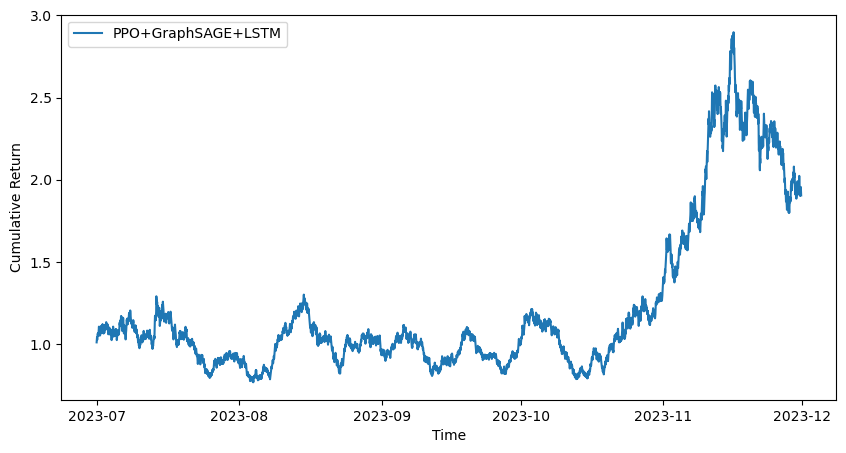

In [103]:

# ------------------------------------------------------------
# 8. TEST & PLOT
# ------------------------------------------------------------
test_env = CryptoPortfolioEnv(states_full[mask_test], rets_full[mask_test],0.0002,0.1,0.01)
test_sh = evaluate_env(test_env, model)
print("Test Sharpe:", test_sh)

# Plot cumulative return
pnls, done = [], False
obs, hidden = test_env.reset(), model.init_hidden()
while not done:
    x, hidden = torch.from_numpy(obs).float().unsqueeze(0).unsqueeze(0).to(DEVICE), hidden
    logits, _, hidden = model(x, hidden)
    a = int(Categorical(logits=logits).probs.argmax().item())
    obs, r, done, _ = test_env.step(a)
    pnls.append(r)
    if done:
        hidden = model.init_hidden()

pnls = np.array(pnls, dtype=np.float32)
cum  = np.cumprod(1 + pnls)
times= times_full[mask_test][:len(cum)]

plt.figure(figsize=(10,5))
plt.plot(times, cum, label="PPO+GraphSAGE+LSTM")
plt.xlabel("Time"); plt.ylabel("Cumulative Return"); plt.legend(); plt.show()